<a href="https://colab.research.google.com/github/vishwas-yogi/Neural-Style-Transfer/blob/main/A_Neural_Algorithm_of_Artistic_Style.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is my attempt at implementing the Neural Style Algorithm proposed by Gatys in the paper <a href= 'https://arxiv.org/abs/1508.06576?source=post_page---------------------------'> A Neural Algorithm of Artistic Style. </a> </br>


Testing Part </br>
Neural Style Transfer algorithm is implemented after this section. </br>
This section can be helpful for understanding some basic concept. </br> But one can skip to the latter section, if one wishes.

In [1]:
import tensorflow as tf
import skimage
import cv2 as cv 
from skimage.transform import resize 
from skimage.color import rgba2rgb
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG19
import os
from tensorflow.keras import Model
from skimage.io import imread

Trying out some different layers for content and style extraction. </br>
By constructing content and style from different layers, we can get the best suitable layers for our cause.

In [16]:
content_image = cv.imread('/content/yogi.jpg')
content_image = resize(content_image, (500, 600), anti_aliasing= True)
content_image = content_image[tf.newaxis, :] #adding an additional axis as vgg input requires min_ndims= 4
print(content_image.shape)

(1, 500, 600, 3)


In [7]:
#layers in vgg
vgg = VGG19(include_top= False, weights= 'imagenet')
for(i, layer) in enumerate(vgg.layers):
  print(f'{i}\t{layer.name}')

80142336/80134624 [==============================] - 0s 0us/step
0	input_1
1	block1_conv1
2	block1_conv2
3	block1_pool
4	block2_conv1
5	block2_conv2
6	block2_pool
7	block3_conv1
8	block3_conv2
9	block3_conv3
10	block3_conv4
11	block3_pool
12	block4_conv1
13	block4_conv2
14	block4_conv3
15	block4_conv4
16	block4_pool
17	block5_conv1
18	block5_conv2
19	block5_conv3
20	block5_conv4
21	block5_pool


In [8]:
print(vgg.inputs)
print(vgg.get_layer('block5_conv2').output)

[<KerasTensor: shape=(None, None, None, 3) dtype=float32 (created by layer 'input_1')>]
KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 512), dtype=tf.float32, name=None), name='block5_conv2/Relu:0', description="created by layer 'block5_conv2'")


In [9]:
"""Selecting Layers for content and style extraction"""
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

content_layers = ['block5_conv2']

In [10]:
content_outputs = [vgg.get_layer(x).output for x in content_layers]
model_content = Model(vgg.input, content_outputs)

In [17]:
def features_extraction(image):
  image = tf.keras.applications.vgg19.preprocess_input(image*255)
  content_ref = model_content(image)
  return content_ref
# content_image = tf.reverse(content_image, axis= [-1])
content_ref = features_extraction(content_image)

In [20]:
"""
Initialising a random image of same shape as that of content image,
we will calculate loss based on the features extracted by this image and we will update it using backpropagation.
"""
image_rand = tf.Variable(tf.random.normal(shape = content_image.shape))

In [21]:
"""
Calculating simple Mean Squared Error,
here y_true = features extracted from content image
y_pred = features extracted from randomly initialized image
"""
def cal_loss(y_true, y_pred):
  loss = [tf.reduce_sum((x - y)**2) for x, y in zip(y_pred, y_true)]
  return tf.reduce_mean(loss)

In [22]:
#initializing optimizer
optimizer = tf.keras.optimizers.Adam(0.02,  beta_1=0.99, epsilon=1e-1)

Reconstructing Content 

In [24]:
#training for 1000 steps
"""Gradient Descent"""
for i in range(0, 1000):
  if(i%100==0):
    print(f'{i}/1000 steps completed')
  with tf.GradientTape() as tape:
    content_features = features_extraction(image_rand)
    loss = cal_loss(content_features, content_ref)
  grad = tape.gradient(loss, image_rand)
  optimizer.apply_gradients([(grad, image_rand)])
  image_rand.assign(tf.clip_by_value(image_rand, 0., 1.))

0/1000 steps completed
100/1000 steps completed
200/1000 steps completed
300/1000 steps completed
400/1000 steps completed
500/1000 steps completed
600/1000 steps completed
700/1000 steps completed
800/1000 steps completed
900/1000 steps completed


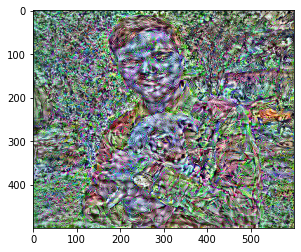

In [25]:
plt.imshow(tf.squeeze(image_rand))
plt.show()
"""
We can see the content reconstruted from block5_conv2 has important content features
but lack style features.
Hence, it can be used for content formation.
"""

In [ ]:
"""
Similar ways can be used to reconstruct style by using different layers.
After testing different layers and getting assured that our recontruction technique is working,
we can now implement our model which can reconstruct image using content from one image and style from other.
"""

**Neural Style Transfer**

In [26]:
#loading and scaling image accordingly
def load_and_scale_image(path):
  image = tf.io.read_file(path)
  image = tf.io.decode_image(image, channels= 3)
  image = tf.image.convert_image_dtype(image, tf.float32)

  max_dim = 512
  scale = np.max(image.shape)/ max_dim
  new_shape = tf.cast(image.shape[:2]/scale, tf.int32)
  scaled_image = tf.image.resize(image, new_shape)
  scaled_image = scaled_image[tf.newaxis, :]
  return scaled_image

In [27]:
def show_image(image, title= None):
  if(len(image.shape)> 3):
    image =tf.squeeze(image, axis= 0) """Using tf.squeeze() to remove the batch dimension
     (1, height, width, channels) to (height, width, channels) to remove the extra dimension, we included."""

  plt.imshow(image)
  if(plt.title):
    plt.title(title, fontsize= 15)

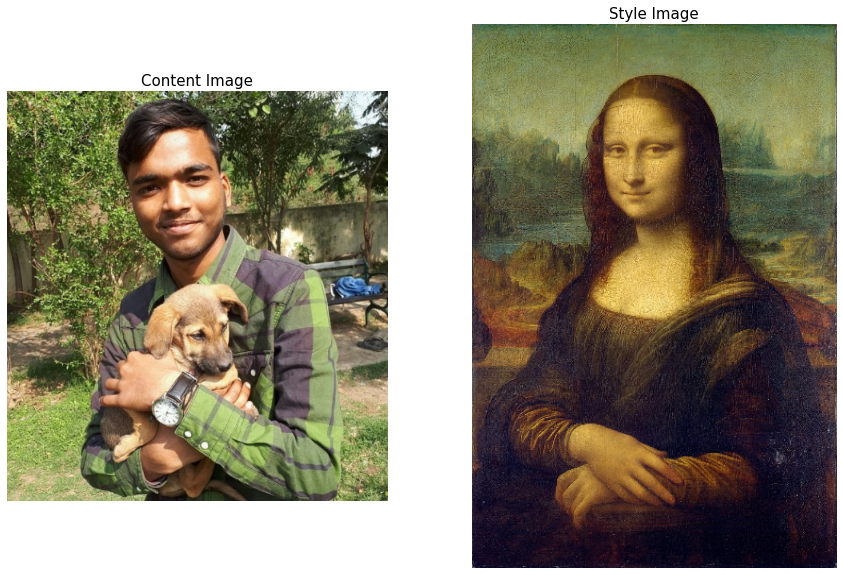

In [28]:
content_path = '/content/yogi.jpg'
style_path = '/content/800px-Mona_Lisa,_by_Leonardo_da_Vinci,_from_C2RMF_retouched.jpg'

content_image = load_and_scale_image(content_path)
style_image = load_and_scale_image(style_path)

plt.figure(figsize= (15, 10))
plt.subplot(1, 2, 1), plt.axis('off')
show_image(content_image, 'Content Image')
plt.subplot(1, 2, 2), plt.axis('off')
show_image(style_image, 'Style Image')

In [ ]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
for(i, layer) in enumerate(vgg.layers):
  print(f'{i}\t{layer.name}')

0	input_1
1	block1_conv1
2	block1_conv2
3	block1_pool
4	block2_conv1
5	block2_conv2
6	block2_pool
7	block3_conv1
8	block3_conv2
9	block3_conv3
10	block3_conv4
11	block3_pool
12	block4_conv1
13	block4_conv2
14	block4_conv3
15	block4_conv4
16	block4_pool
17	block5_conv1
18	block5_conv2
19	block5_conv3
20	block5_conv4
21	block5_pool


In [ ]:
#defining content and style layers for feature extraction
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

content_layers = ['block5_conv2']

In [ ]:
#constructing model for feature extraction
content_outputs = [vgg.get_layer(layer).output for layer in content_layers]
style_outputs = [vgg.get_layer(layer).output for layer in style_layers]
model = Model(vgg.input, [content_outputs, style_outputs])

In [ ]:
#as suggested in the paper, using Gram Matrix for style extraction.
"""
Use tf.squeeze() to remove the batch dimension (1, height, width, channels) to (height, width, channels)
as the batch size is always 1.,
Transposing the tensor from (height, width, channels) to (channels, height, width),
Flattening the final two dimensions to make it (channels, height X width),
Performing the dot product of features to get Gram Matrix of shape (channels X channels)
"""
def gram_matrix(x):
  x = tf.transpose(tf.squeeze(x), (2,0,1))
  x = tf.keras.backend.batch_flatten(x)
  num_points = x.shape[-1]
  gram = tf.linalg.matmul(x, tf.transpose(x))/num_points
  return gram

In [ ]:
"""Function used for extracting style and content features"""
def feature_extractor(image):
  image = tf.keras.applications.vgg19.preprocess_input(image*255.)
  contents, styles = model(image)
  styles = [gram_matrix(style) for style in styles]
  return contents, styles

In [ ]:
"""using the same mse as mentioned in the previous section"""
def calc_loss(y_true, y_pred):
  loss = [tf.reduce_sum((x - y)**2) for x, y in zip(y_pred, y_true)]
  return tf.reduce_mean(loss)

In [ ]:
#initializing an Adam optimizer
optimizer = tf.keras.optimizers.Adam(0.02,  beta_1=0.99, epsilon=1e-1)

In [ ]:
"""Training Function"""
@tf.function()
def train(image_stylized, content_true, style_true, c_weight, s_weight):
  """Gradient descent"""
  with tf.GradientTape() as tape:
    content_features, style_features = feature_extractor(image_stylized)
    content_loss = calc_loss(content_true, content_features)
    style_loss = calc_loss(style_true, style_features)
    loss = c_weight * content_loss + s_weight * style_loss
  
  grad = tape.gradient(loss, image_stylized)
  optimizer.apply_gradients([(grad, image_stylized)])
  image_stylized.assign(tf.clip_by_value(image_stylized, 0., 1.))
  
  return c_weight*content_loss, s_weight*style_loss

In [ ]:
def neural_style_transfer(content_image, style_image, epochs=10, alpha= 1, beta= 1e-5):
  # content_image = content_image/255.0
  # style_image = style_image/255.0

  # plt.imshow(tf.squeeze(style_image, axis= 0))
  content_true, _ = feature_extractor(content_image)
  _ , style_true = feature_extractor(style_image)

  """
  Initialising an image for gradient descent.
  As mentioned in the paper, we can also initiate our content image for gradient descent.
  Hence, using content image as initial image.
  """
  image_stylized = tf.Variable(content_image)

  steps_per_epoch= 100

  import time
  start = time.time()

  print('[INFO] Training Starting...')
  for i in range(0, epochs):
    for j in range(0, steps_per_epoch):
      content_loss, style_loss = train(image_stylized, content_true, style_true, c_weight= alpha, s_weight= beta)
    print(f'Epoch Ended: {i+1}\t time_elapsed{time.time()- start}')

  plt.figure(figsize=(10,8))
  plt.imshow(tf.squeeze(image_stylized, axis= 0))
  plt.axis('off')
  plt.show()



  return image_stylized

Testing by implementing with different weights and different styling images.

[INFO] Training Starting...
Epoch Ended: 1	 time_elapsed32.171918630599976
Epoch Ended: 2	 time_elapsed64.09565305709839
Epoch Ended: 3	 time_elapsed95.9826078414917
Epoch Ended: 4	 time_elapsed127.92043948173523
Epoch Ended: 5	 time_elapsed159.96633338928223
Epoch Ended: 6	 time_elapsed192.02960181236267
Epoch Ended: 7	 time_elapsed224.08909964561462
Epoch Ended: 8	 time_elapsed256.1403543949127
Epoch Ended: 9	 time_elapsed288.21270275115967
Epoch Ended: 10	 time_elapsed320.2679829597473


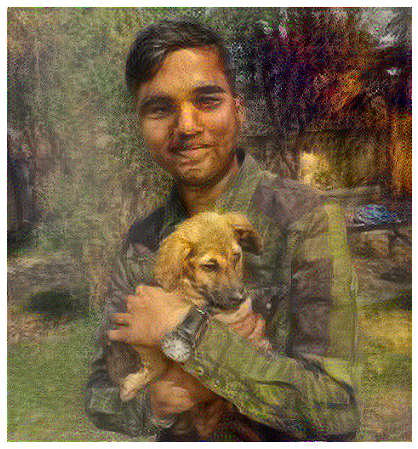

In [ ]:
image = neural_style_transfer(content_image, style_image, epochs= 10, alpha=1e4, beta= 1e-2)

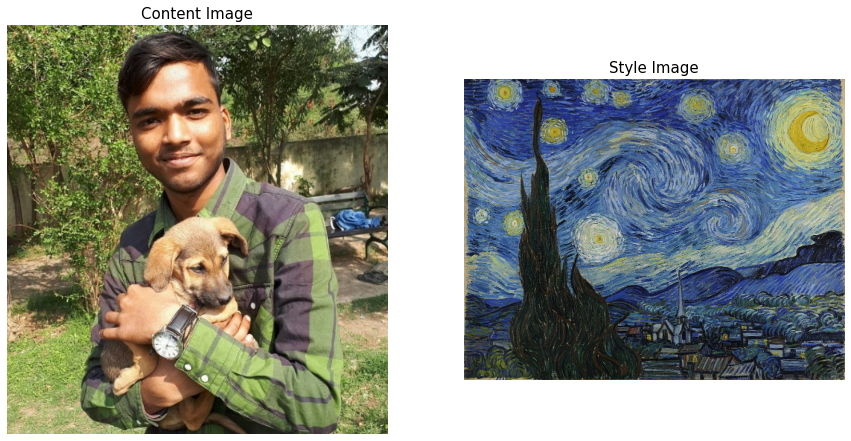

In [ ]:
content_image = load_and_scale_image('/content/yogi.jpg')
style_image = load_and_scale_image('/content/1024px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg')

plt.figure(figsize= (15, 10))
plt.subplot(1, 2, 1), plt.axis('off')
show_image(content_image, 'Content Image')
plt.subplot(1, 2, 2), plt.axis('off')
show_image(style_image, 'Style Image')

[INFO] Training Starting...
Epoch Ended: 1	 time_elapsed12.068754434585571
Epoch Ended: 2	 time_elapsed21.290528535842896
Epoch Ended: 3	 time_elapsed30.8643696308136
Epoch Ended: 4	 time_elapsed40.79656505584717
Epoch Ended: 5	 time_elapsed50.89125370979309
Epoch Ended: 6	 time_elapsed60.665581464767456
Epoch Ended: 7	 time_elapsed70.1724317073822
Epoch Ended: 8	 time_elapsed79.52212858200073
Epoch Ended: 9	 time_elapsed88.82175254821777
Epoch Ended: 10	 time_elapsed98.15450167655945


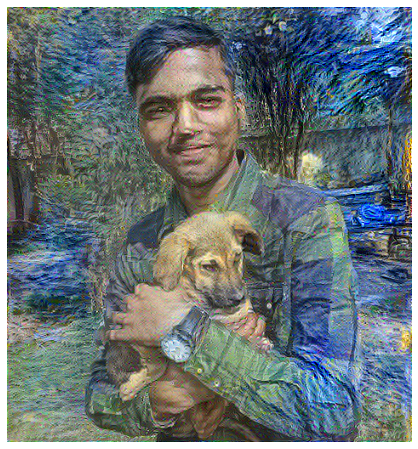

In [ ]:
image = neural_style_transfer(content_image, style_image, epochs= 10, alpha=1e4, beta= 1e-2)

[INFO] Training Starting...
Epoch Ended: 1	 time_elapsed32.52310109138489
Epoch Ended: 2	 time_elapsed64.47163224220276
Epoch Ended: 3	 time_elapsed96.31890273094177
Epoch Ended: 4	 time_elapsed128.13112211227417
Epoch Ended: 5	 time_elapsed159.93121528625488
Epoch Ended: 6	 time_elapsed191.74317288398743
Epoch Ended: 7	 time_elapsed223.53690004348755
Epoch Ended: 8	 time_elapsed255.3230106830597
Epoch Ended: 9	 time_elapsed287.1261055469513
Epoch Ended: 10	 time_elapsed318.91524839401245


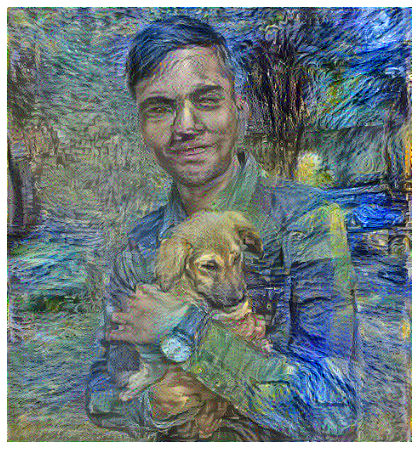

In [ ]:
image = neural_style_transfer(content_image, style_image, epochs= 10, alpha=1, beta= 1e-5)

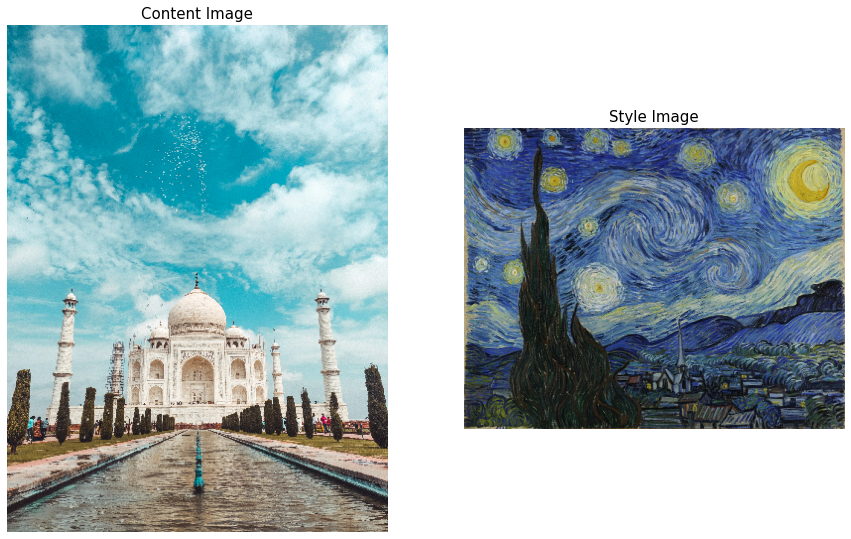

In [ ]:
content_image = load_and_scale_image('/content/pexels-bhavitya-indora-3224533.jpg')
style_image = load_and_scale_image('/content/1024px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg')

plt.figure(figsize= (15, 10))
plt.subplot(1, 2, 1), plt.axis('off')
show_image(content_image, 'Content Image')
plt.subplot(1, 2, 2), plt.axis('off')
show_image(style_image, 'Style Image')

[INFO] Training Starting...
Epoch Ended: 1	 time_elapsed10.488045454025269
Epoch Ended: 2	 time_elapsed18.43442940711975
Epoch Ended: 3	 time_elapsed26.329859256744385
Epoch Ended: 4	 time_elapsed33.92664051055908
Epoch Ended: 5	 time_elapsed41.34322905540466
Epoch Ended: 6	 time_elapsed48.61756205558777
Epoch Ended: 7	 time_elapsed55.81238007545471
Epoch Ended: 8	 time_elapsed62.98974108695984
Epoch Ended: 9	 time_elapsed70.19044518470764
Epoch Ended: 10	 time_elapsed77.4673399925232


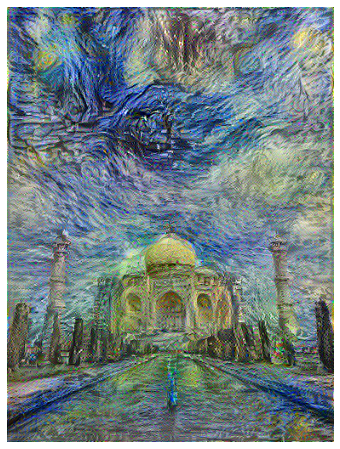

In [ ]:
image = neural_style_transfer(content_image, style_image, epochs= 10, alpha=1, beta= 1e-5)

**Future Work**:</br>
Research has developed many efficient implementation of this algorithm. </br>
This algorithm even on GPU takes 4-5 min to produce the image. Hence, not suitable for stream of images.</br>
Also, different methods have been developed for extracting style other than gram matrix. </br>
I will also be working in the same directions to make style extraction better and to transfer style to stream of images.